In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier

### 1. Exploratory Data Analysis

In [2]:
df = pd.read_excel('data/train_file.xlsx')
df

age           job   marital            education  default  housing  \
0       49   blue-collar   married             basic.9y  unknown       no   
1       37  entrepreneur   married    university.degree       no       no   
2       78       retired   married             basic.4y       no       no   
3       36        admin.   married    university.degree       no      yes   
4       59       retired  divorced    university.degree       no       no   
...    ...           ...       ...                  ...      ...      ...   
32905   30    management    single    university.degree       no       no   
32906   34   blue-collar   married          high.school       no      yes   
32907   33    technician   married  professional.course       no      yes   
32908   58    unemployed   married             basic.9y       no       no   
32909   39   blue-collar    single             basic.4y  unknown  unknown   

          loan    contact month day_of_week  duration  campaign  previous  \
0           no   cellular   nov         wed       227         4         0   
1           no  telephone   nov         wed       202         2         1   
2           no   cellular   jul         mon      1148         1         0   
3           no  telephone   may         mon       120         2         0   
4           no   cellular   jun         tue       368         2         0   
...        ...        ...   ...         ...       ...       ...       ...   
32905       no   cellular   nov         thu       197         5         1   
32906       no  telephone   jun         mon       562         3         0   
32907      yes   cellular   aug         mon        61         1         0   
32908       no  telephone   jun         mon       266         2         0   
32909  unknown  telephone   may         wed        64         1         0   

          poutcome    y  
0      nonexistent   no  
1          failure   no  
2      nonexistent  yes  
3      nonexistent   no  
4      nonexistent   no  
...            ...  ...  
32905      failure   no  
32906  nonexistent   no  
32907  nonexistent   no  
32908  nonexistent   no  
32909  nonexistent   no  

[32910 rows x 15 columns]

- default: Does the client have credit in default.
- housing: Does the client have a house?
- loan: does the customer have a housing loan?
- previous: how many times has the customer been contacted previously?
- poutcome: "previous outcome" might refer to the result of a previous marketing campaign. Did they buy the product in a previous campaign?
- y: this is the target. Did the call end up in a the customer buying the product?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32910 entries, 0 to 32909
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          32910 non-null  int64 
 1   job          32910 non-null  object
 2   marital      32910 non-null  object
 3   education    32910 non-null  object
 4   default      32910 non-null  object
 5   housing      32910 non-null  object
 6   loan         32910 non-null  object
 7   contact      32910 non-null  object
 8   month        32910 non-null  object
 9   day_of_week  32910 non-null  object
 10  duration     32910 non-null  int64 
 11  campaign     32910 non-null  int64 
 12  previous     32910 non-null  int64 
 13  poutcome     32910 non-null  object
 14  y            32910 non-null  object
dtypes: int64(4), object(11)
memory usage: 3.8+ MB


Results show that we have integers and strings (object). The strings will need to be encoded for a better EDA and for training the model
. Also important: there are no null values.

In [ ]:
categorical_columns = [x for x in df.columns if df[x].dtype == np.dtype('object')]
numerical_columns   = [x for x in df.columns if x not in(categorical_columns)]



# we remove "month in order to label it manually with a perfect logic"
categorical_columns.remove('month') 
categorical_columns.remove('day_of_week') 

data = {'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']}
month_mapping = {
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
}
# Manually encode the "month" column
df['month'] = df['month'].map(month_mapping)


data = {'day_of_week': ['mon', 'tue', 'wed', 'thu', 'fri']}
week_mapping = {
    'mon': 1,
    'tue': 2,
    'wed': 3,
    'thu': 4,
    'fri': 5,
}
# Manually encode the "day_of_week" column
df['day_of_week'] = df['day_of_week'].map(week_mapping)

In [5]:
df

age           job   marital            education  default  housing  \
0       49   blue-collar   married             basic.9y  unknown       no   
1       37  entrepreneur   married    university.degree       no       no   
2       78       retired   married             basic.4y       no       no   
3       36        admin.   married    university.degree       no      yes   
4       59       retired  divorced    university.degree       no       no   
...    ...           ...       ...                  ...      ...      ...   
32905   30    management    single    university.degree       no       no   
32906   34   blue-collar   married          high.school       no      yes   
32907   33    technician   married  professional.course       no      yes   
32908   58    unemployed   married             basic.9y       no       no   
32909   39   blue-collar    single             basic.4y  unknown  unknown   

          loan    contact  month  day_of_week  duration  campaign  previous  \
0           no   cellular     11            3       227         4         0   
1           no  telephone     11            3       202         2         1   
2           no   cellular      7            1      1148         1         0   
3           no  telephone      5            1       120         2         0   
4           no   cellular      6            2       368         2         0   
...        ...        ...    ...          ...       ...       ...       ...   
32905       no   cellular     11            4       197         5         1   
32906       no  telephone      6            1       562         3         0   
32907      yes   cellular      8            1        61         1         0   
32908       no  telephone      6            1       266         2         0   
32909  unknown  telephone      5            3        64         1         0   

          poutcome    y  
0      nonexistent   no  
1          failure   no  
2      nonexistent  yes  
3      nonexistent   no  
4      nonexistent   no  
...            ...  ...  
32905      failure   no  
32906  nonexistent   no  
32907  nonexistent   no  
32908  nonexistent   no  
32909  nonexistent   no  

[32910 rows x 15 columns]

In [16]:
for col in categorical_columns:
    print(f"Column: {col}")
    print(df[col].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')
    print("#"*40)

Column: job
job
admin.           25.24%
blue-collar      22.58%
technician       16.38%
services           9.7%
management        7.12%
retired           4.14%
entrepreneur      3.52%
self-employed     3.34%
housemaid          2.6%
unemployed        2.42%
student           2.16%
unknown            0.8%
Name: proportion, dtype: object
########################################
Column: marital
marital
married     60.56%
single      28.09%
divorced    11.15%
unknown       0.2%
Name: proportion, dtype: object
########################################
Column: education
education
university.degree      29.56%
high.school            23.05%
basic.9y               14.64%
professional.course    12.71%
basic.4y               10.09%
basic.6y                5.66%
unknown                 4.24%
illiterate              0.05%
Name: proportion, dtype: object
########################################
Column: default
default
no         78.93%
unknown    21.06%
yes         0.01%
Name: proportion, dtype: object

Previous conclusion: Most of the people (88.74%) won't subscribe
TARGET IMBALANCED! WE NEED TO BE CAREFUL (when we create the model, the model might be biased toward predicting the majority class (customer not buying the product)).
We are going to apply the SMOTE technique in order to mitigate this effect

In [17]:
# we convert the call duration to minutes for standarization
df['duration']=df['duration']/60

In [18]:
df.describe().astype(int)  # will perform only for numerical columns

age  duration  campaign  previous
count  32910     32910     32910     32910
mean      40         4         2         0
std       10         4         2         0
min       17         0         1         0
25%       32         1         1         0
50%       38         3         2         0
75%       47         5         3         0
max       98        81        56         7

Let's encode the categorical variables

In [19]:
label_encoders = {}  # Store encoders for inverse transform if needed

for col in categorical_columns:  
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

    # Convert np.int64 values to regular integers
    mapping = {key: int(value) for key, value in zip(label_encoders[col].classes_, label_encoders[col].transform(label_encoders[col].classes_))}

    # Print the mapping of original values to encoded values
    print(f"Column: {col}")
    print(mapping)
    print("#"*30)

Column: job
{'admin.': 0, 'blue-collar': 1, 'entrepreneur': 2, 'housemaid': 3, 'management': 4, 'retired': 5, 'self-employed': 6, 'services': 7, 'student': 8, 'technician': 9, 'unemployed': 10, 'unknown': 11}
##############################
Column: marital
{'divorced': 0, 'married': 1, 'single': 2, 'unknown': 3}
##############################
Column: education
{'basic.4y': 0, 'basic.6y': 1, 'basic.9y': 2, 'high.school': 3, 'illiterate': 4, 'professional.course': 5, 'university.degree': 6, 'unknown': 7}
##############################
Column: default
{'no': 0, 'unknown': 1, 'yes': 2}
##############################
Column: housing
{'no': 0, 'unknown': 1, 'yes': 2}
##############################
Column: loan
{'no': 0, 'unknown': 1, 'yes': 2}
##############################
Column: contact
{'cellular': 0, 'telephone': 1}
##############################
Column: month
{'apr': 0, 'aug': 1, 'dec': 2, 'jul': 3, 'jun': 4, 'mar': 5, 'may': 6, 'nov': 7, 'oct': 8, 'sep': 9}
############################

In [20]:
df

age  job  marital  education  default  housing  loan  contact  month  \
0       49    1        1          2        1        0     0        0      7   
1       37    2        1          6        0        0     0        1      7   
2       78    5        1          0        0        0     0        0      3   
3       36    0        1          6        0        2     0        1      6   
4       59    5        0          6        0        0     0        0      4   
...    ...  ...      ...        ...      ...      ...   ...      ...    ...   
32905   30    4        2          6        0        0     0        0      7   
32906   34    1        1          3        0        2     0        1      4   
32907   33    9        1          5        0        2     2        0      1   
32908   58   10        1          2        0        0     0        1      4   
32909   39    1        2          0        1        1     1        1      6   

       day_of_week   duration  campaign  previous  poutcome  y  
0                4   3.783333         4         0         1  0  
1                4   3.366667         2         1         0  0  
2                1  19.133333         1         0         1  1  
3                1   2.000000         2         0         1  0  
4                3   6.133333         2         0         1  0  
...            ...        ...       ...       ...       ... ..  
32905            2   3.283333         5         1         0  0  
32906            1   9.366667         3         0         1  0  
32907            1   1.016667         1         0         1  0  
32908            1   4.433333         2         0         1  0  
32909            4   1.066667         1         0         1  0  

[32910 rows x 15 columns]

No one hot encoding has been performed in this notebook. 
I did some tests but no improvement in terms of accuracy was observed and it slowed down the models training due to the increased number of features

Let's check histograms now to see tendencies and to check if there are outliers in the database:

<function matplotlib.pyplot.show(close=None, block=None)>

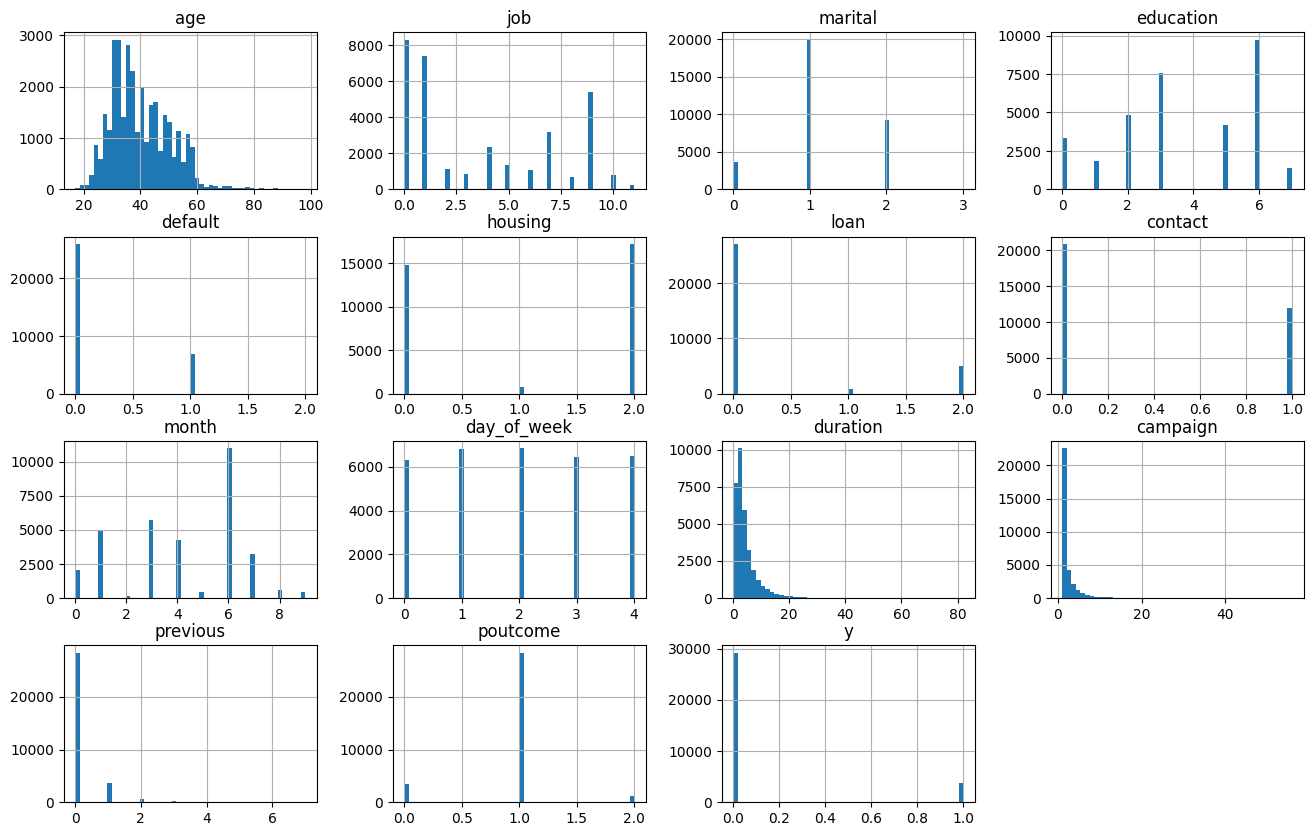

In [21]:
df.hist(bins=50, figsize=(16,10))
plt.show

Let's standarize variables that make sense to standarize

In [22]:
# List of numerical features to be standardized:
standarizable_features = ['age','campaign']
# Initialize the StandardScaler:
scaler = StandardScaler()
# Standardize the numerical features:
df[standarizable_features] = scaler.fit_transform(df[standarizable_features])
# We save the scaler for performing predictions:
with open("scaler/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [23]:
df

age  job  marital  education  default  housing  loan  contact  \
0      0.863797    1        1          2        1        0     0        0   
1     -0.289739    2        1          6        0        0     0        1   
2      3.651511    5        1          0        0        0     0        0   
3     -0.385868    0        1          6        0        2     0        1   
4      1.825078    5        0          6        0        0     0        0   
...         ...  ...      ...        ...      ...      ...   ...      ...   
32905 -0.962636    4        2          6        0        0     0        0   
32906 -0.578124    1        1          3        0        2     0        1   
32907 -0.674252    9        1          5        0        2     2        0   
32908  1.728950   10        1          2        0        0     0        1   
32909 -0.097483    1        2          0        1        1     1        1   

       month  day_of_week   duration  campaign  previous  poutcome  y  
0          7            4   3.783333  0.522785         0         1  0  
1          7            4   3.366667 -0.203618         1         0  0  
2          3            1  19.133333 -0.566819         0         1  1  
3          6            1   2.000000 -0.203618         0         1  0  
4          4            3   6.133333 -0.203618         0         1  0  
...      ...          ...        ...       ...       ...       ... ..  
32905      7            2   3.283333  0.885986         1         0  0  
32906      4            1   9.366667  0.159583         0         1  0  
32907      1            1   1.016667 -0.566819         0         1  0  
32908      4            1   4.433333 -0.203618         0         1  0  
32909      6            4   1.066667 -0.566819         0         1  0  

[32910 rows x 15 columns]

Let's look for outliers visually using boxplots:

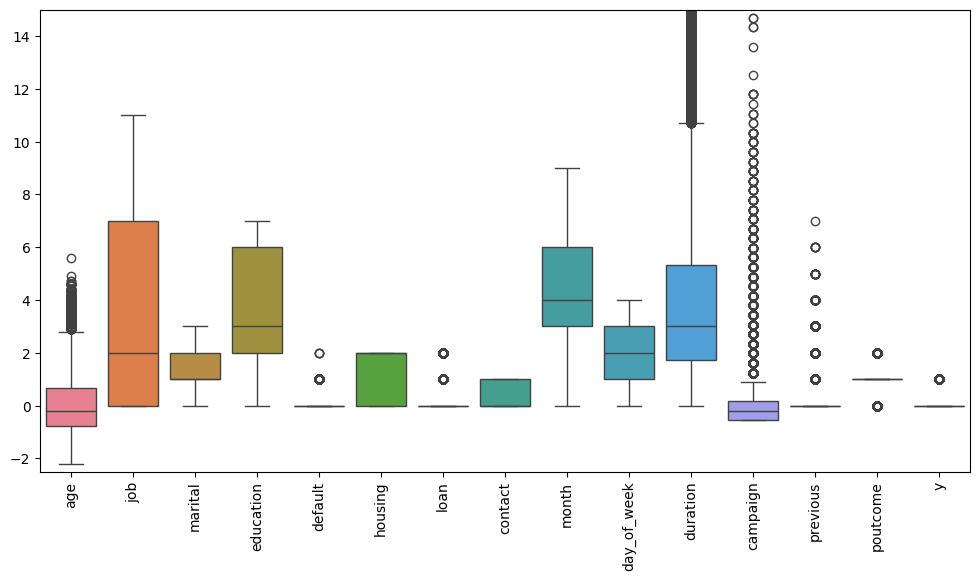

In [24]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)  
plt.ylim(-2.5, 15)
plt.show()

Outliers analyisis:

- age: values between 17 and 98 years old. Seems reasonable, we will not touch it
- default: only 3 unique values in this column: "yes", "no", "unknown". Seems reasonable, we will not touch it 
- loan: only 3 unique values in this column: "yes", "no", "unknown". Seems reasonable, we will not touch it 
- duration: values between 0 and 82 minutes. Seems reasonable, we will not touch it 
- campaign: values between 1 and 56. Seems reasonable, we will not touch it 
- previous: values between 0 and 7 previous calls. Seems reasonable, we will not touch it
- poutcome: only 3 unique values in this column: 'nonexistent', 'failure', 'success'. Seems reasonable, we will not touch it 
- y is the target with "no" or "yes" values. We will not touch it

Let's see correlations among variables with a heatmap:

<Axes: >

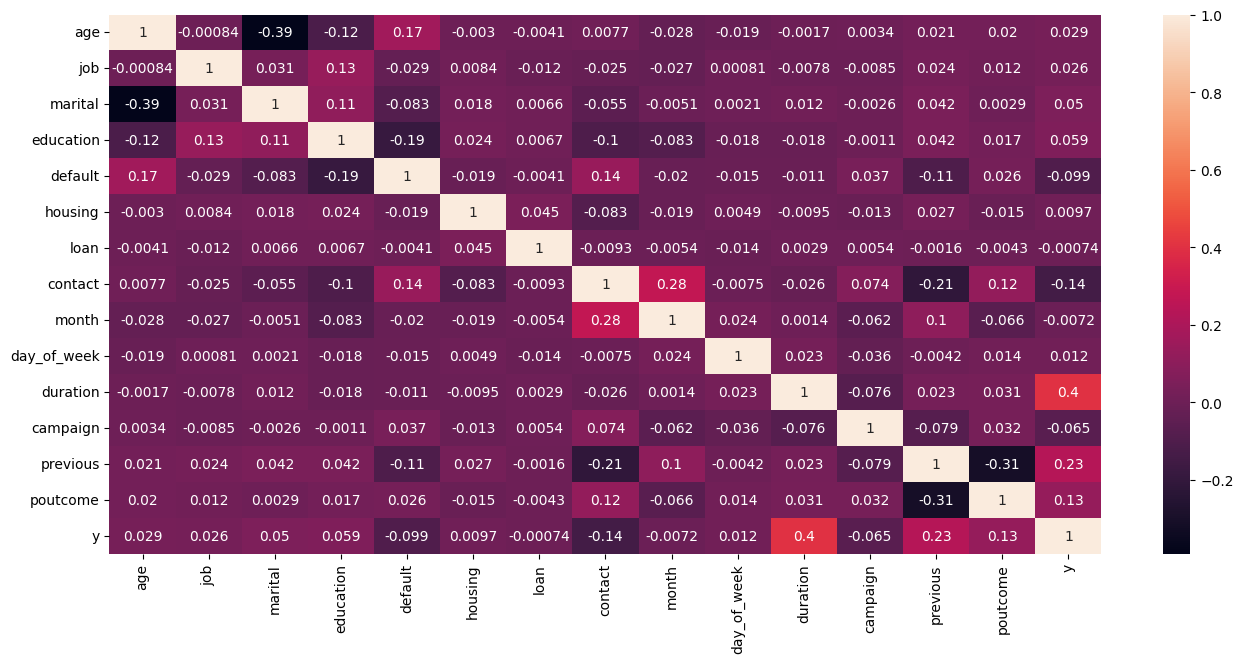

In [25]:
plt.figure(figsize=(16,7))
sns.heatmap(df.corr(),annot=True)

- Very interesting and obvious positive correlation between "duration" and "y". People who end up buying the product stay longer on the phone for getting information and performing the purchase.
- Interesting positive correlation between "previous" and "y". People who have already bought a product have more chances to buy another one.

### 2. Evaluation of different machine learning models:

In [26]:
df

age  job  marital  education  default  housing  loan  contact  \
0      0.863797    1        1          2        1        0     0        0   
1     -0.289739    2        1          6        0        0     0        1   
2      3.651511    5        1          0        0        0     0        0   
3     -0.385868    0        1          6        0        2     0        1   
4      1.825078    5        0          6        0        0     0        0   
...         ...  ...      ...        ...      ...      ...   ...      ...   
32905 -0.962636    4        2          6        0        0     0        0   
32906 -0.578124    1        1          3        0        2     0        1   
32907 -0.674252    9        1          5        0        2     2        0   
32908  1.728950   10        1          2        0        0     0        1   
32909 -0.097483    1        2          0        1        1     1        1   

       month  day_of_week   duration  campaign  previous  poutcome  y  
0          7            4   3.783333  0.522785         0         1  0  
1          7            4   3.366667 -0.203618         1         0  0  
2          3            1  19.133333 -0.566819         0         1  1  
3          6            1   2.000000 -0.203618         0         1  0  
4          4            3   6.133333 -0.203618         0         1  0  
...      ...          ...        ...       ...       ...       ... ..  
32905      7            2   3.283333  0.885986         1         0  0  
32906      4            1   9.366667  0.159583         0         1  0  
32907      1            1   1.016667 -0.566819         0         1  0  
32908      4            1   4.433333 -0.203618         0         1  0  
32909      6            4   1.066667 -0.566819         0         1  0  

[32910 rows x 15 columns]

When splitting the data into training and testing sets, use stratified sampling to maintain the same class distribution in both sets. 
This ensures that the distribution of 1s and 0s is similar in both the training and test sets, preventing the model from being biased.
I tried smote and it does not generalize well, it seemed to overfit and the model became biased toward predicting "1" too often.

In [27]:
X = df.drop(['y'], axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Let's define a function with all the metrics for evaluating the models' performances:

In [28]:
def evaluation(name,model):

    # Define cross-validation strategy (5-fold Stratified)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print("#" * 80)
    print(name)

    # Perform cross-validation and calculate mean accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"Cross-Validation Accuracy Scores: {cv_scores}")
    print(f"Mean Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

    # Fit model on full training data
    #model.fit(X_train, y_train)

    # Fit model on SMOTE training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Test Set Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(classification_report(y_test, y_pred))

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.show()

    return()

Let's try 3 typical models for classification. We could try more but I will just try this 3 because they are significative. We could also try Decision trees, Support Vector Machines... 
We are going to compare the models with default hyperparameters and once we have decided the model we will add cross validation and finetune the hyperparameters.

################################################################################
LOGISTIC_REGRESSION
Cross-Validation Accuracy Scores: [0.90104167 0.90147569 0.90253961 0.90753202 0.89863252]
Mean Accuracy: 0.9022 ± 0.0029
Test Set Accuracy: 0.9004
Confusion Matrix:
[[8578  183]
 [ 800  312]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      8761
           1       0.63      0.28      0.39      1112

    accuracy                           0.90      9873
   macro avg       0.77      0.63      0.67      9873
weighted avg       0.88      0.90      0.88      9873



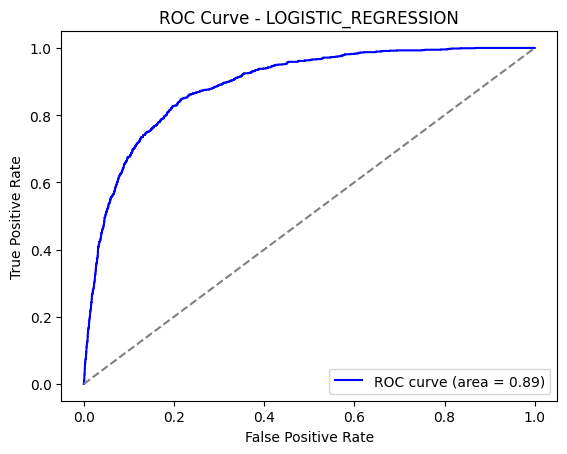

################################################################################
RANDOM_FOREST
Cross-Validation Accuracy Scores: [0.90625    0.90451389 0.9042761  0.9031908  0.89993488]
Mean Accuracy: 0.9036 ± 0.0021
Test Set Accuracy: 0.9060
Confusion Matrix:
[[8511  250]
 [ 678  434]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      8761
           1       0.63      0.39      0.48      1112

    accuracy                           0.91      9873
   macro avg       0.78      0.68      0.72      9873
weighted avg       0.89      0.91      0.90      9873



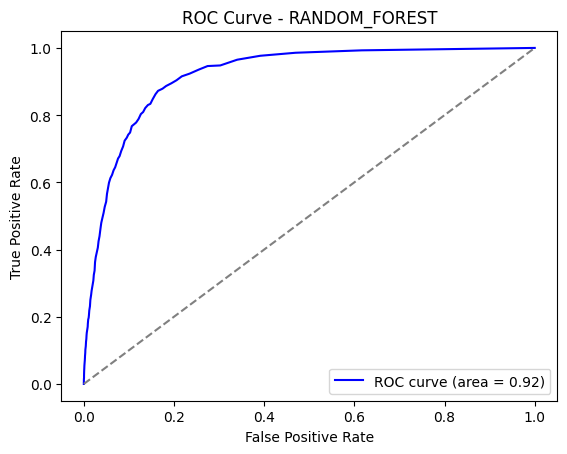

################################################################################
XGBOOST
Cross-Validation Accuracy Scores: [0.90885417 0.90755208 0.90123725 0.9081832  0.90340786]
Mean Accuracy: 0.9058 ± 0.0030
Test Set Accuracy: 0.9070
Confusion Matrix:
[[8428  333]
 [ 585  527]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      8761
           1       0.61      0.47      0.53      1112

    accuracy                           0.91      9873
   macro avg       0.77      0.72      0.74      9873
weighted avg       0.90      0.91      0.90      9873



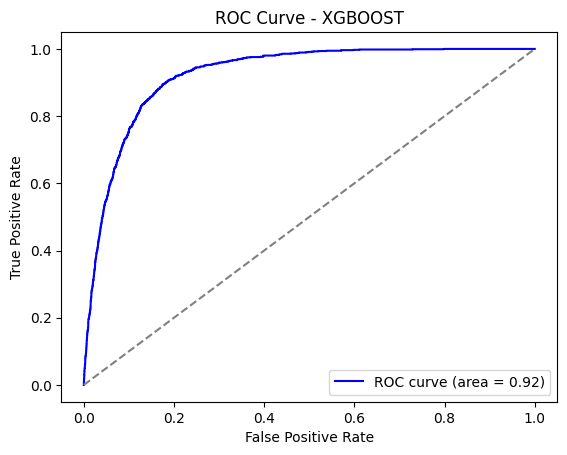

In [29]:
# Define models
models = {
    "LOGISTIC_REGRESSION": LogisticRegression(random_state=42),
    "RANDOM_FOREST": RandomForestClassifier(random_state=42),
    "XGBOOST": XGBClassifier(random_state=42),
    }

for name, model in models.items():
    evaluation(name,model)

# 3. Choosing final model and integrate it in pipeline for inferencing

I will choose for XGBoost. Why?

- Logistic regression performs slightly worse than the other 2 ones.
- Random Forest and XGBoost perform similar. However, Random Forest is stored in a heavier file. This might not be relevant for local inferences,but it 
could create troubles in a potential deployment in a small instance in the cloud.

Let's try to achieve a little improvement of the model's performance by implement cross-validation and trying different hyperparameters with GridSearchCV. When this is done we will save the model with the most accurate hyperparameters. We can add as many hyperparameters and values as we want. However, too many combination would slow down the training process. I will just try some important hyperparameters, including the L1 and L2 regularization ones in order to avoid overfitting

In [30]:
def evaluation_grid_search():
    # Define cross-validation strategy (5-fold Stratified)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Define the model
    model = XGBClassifier(random_state=42)

    # Define the parameter grid for GridSearchCV
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5, 2],  # L1 regularization
        'reg_lambda': [0, 0.1, 0.5, 2]  # L2 regularization
        }

    # Create GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)

    # Fit the model with GridSearchCV
    grid_search.fit(X_train, y_train)

    # Print the best parameters found by GridSearchCV
    print(f"Best Hyperparameters: {grid_search.best_params_}")

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Perform cross-validation and calculate mean accuracy for the best model
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"Cross-Validation Accuracy Scores: {cv_scores}")
    print(f"Mean Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

    # Fit the best model on the full training data
    best_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Test Set Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(classification_report(y_test, y_pred))

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Best Model')
    plt.legend(loc='lower right')
    plt.show()

    # Save the most accurate model in a file for production
    pkl_filename = "models/optimized_xgboost.pkl"  
    with open(pkl_filename, 'wb') as file:  
        pickle.dump(best_model, file)

    return()

Fitting 5 folds for each of 6912 candidates, totalling 34560 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estima

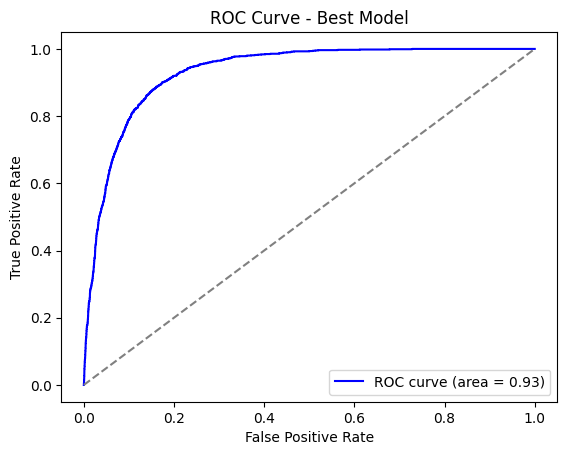

()

In [31]:
evaluation_grid_search()

# 4. Produce predictions and save them in predictions.csv

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier

In [33]:
# We are going to summarize the data pipeline in a fuction so that we can apply it to any input:
def pipeline(df):
    # Let's apply the changes for normalization etc:
    categorical_columns = [x for x in df.columns if df[x].dtype == np.dtype('object')]
    numerical_columns   = [x for x in df.columns if x not in(categorical_columns)]

    df['duration']=df['duration']/60

    label_encoders = {}  # Store encoders for inverse transform if needed

    for col in categorical_columns:  # List of categorical columns
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])


    # List of numerical features to be standardized
    standarizable_features = ['age','campaign']
    # Initialize the StandardScaler
    #scaler = StandardScaler()
    with open("scaler/scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    # Standardize the numerical features
    df[standarizable_features] = scaler.transform(df[standarizable_features])

    return(df)

In [34]:
df = pd.read_excel('data/test_file.xlsx')
df

age            job   marital            education  default  housing  \
0    34       services   married          high.school       no       no   
1    29    blue-collar    single             basic.9y       no       no   
2    35         admin.    single          high.school       no       no   
3    60         admin.  divorced          high.school       no      yes   
4    45     management   married    university.degree       no       no   
5    31    blue-collar   married             basic.9y       no      yes   
6    39    blue-collar   married  professional.course       no       no   
7    67        retired   married  professional.course       no      yes   
8    21        student    single          high.school       no       no   
9    53        retired   married          high.school  unknown       no   
10   51       services   married          high.school  unknown      yes   
11   44         admin.   married  professional.course       no      yes   
12   39     technician    single  professional.course  unknown       no   
13   43     technician    single  professional.course  unknown       no   
14   50         admin.   married             basic.9y       no       no   
15   29     technician   married    university.degree       no       no   
16   55        unknown   married    university.degree  unknown  unknown   
17   54    blue-collar  divorced          high.school  unknown       no   
18   29         admin.    single    university.degree       no       no   
19   51     technician  divorced              unknown  unknown       no   
20   37     technician    single          high.school  unknown      yes   
21   52    blue-collar   married              unknown       no       no   
22   50       services   married          high.school       no      yes   
23   33     technician  divorced  professional.course       no      yes   
24   29    blue-collar    single          high.school       no      yes   
25   28    blue-collar    single             basic.9y       no      yes   
26   32    blue-collar   married             basic.9y       no       no   
27   29     technician    single    university.degree       no      yes   
28   37  self-employed   married    university.degree       no      yes   
29   39    blue-collar   married             basic.6y       no      yes   
30   30     management   married    university.degree       no       no   
31   28    blue-collar    single             basic.9y       no      yes   
32   44   entrepreneur   married  professional.course       no      yes   
33   47         admin.   married             basic.9y       no      yes   
34   29    blue-collar   married             basic.6y       no       no   
35   28       services    single          high.school       no      yes   
36   52     technician   married  professional.course       no      yes   
37   54         admin.   married             basic.9y       no       no   
38   29         admin.   married    university.degree       no       no   
39   35         admin.   married    university.degree       no       no   

       loan    contact month day_of_week  duration  campaign  previous  \
0        no  telephone   may         thu       214         4         0   
1        no   cellular   jul         thu       190         1         0   
2        no   cellular   may         wed       152         2         0   
3        no   cellular   jul         fri       179         1         0   
4        no  telephone   may         wed       105         2         0   
5        no  telephone   may         thu       141         1         0   
6        no  telephone   may         mon        87         5         0   
7       yes   cellular   aug         mon       186         1         0   
8        no   cellular   jun         thu       400         1         0   
9        no  telephone   may         wed       264         2         0   
10       no  telephone   may         thu       102         2         0   
11       no  telephone   may         mon

In [35]:
df_final = pipeline(df)
df_final

age  job  marital  education  default  housing  loan  contact  month  \
0  -0.578124    6        1          2        0        0     0        1      4   
1  -1.058764    1        2          1        0        0     0        0      2   
2  -0.481996    0        2          2        0        0     0        0      4   
3   1.921206    0        0          2        0        2     0        0      2   
4   0.479285    3        1          4        0        0     0        1      4   
5  -0.866508    1        1          1        0        2     0        1      4   
6  -0.097483    1        1          3        0        0     0        1      4   
7   2.594102    4        1          3        0        2     2        0      1   
8  -1.827788    7        2          2        0        0     0        0      3   
9   1.248309    4        1          2        1        0     0        1      4   
10  1.056053    6        1          2        1        2     0        1      4   
11  0.383157    0        1          3        0        2     0        1      4   
12 -0.097483    8        2          3        1        0     0        1      3   
13  0.287029    8        2          3        1        0     0        1      2   
14  0.959925    0        1          1        0        0     0        1      3   
15 -1.058764    8        1          4        0        0     0        1      4   
16  1.440566    9        1          4        1        1     1        1      4   
17  1.344438    1        0          2        1        0     0        0      2   
18 -1.058764    0        2          4        0        0     2        1      3   
19  1.056053    8        0          5        1        0     0        1      2   
20 -0.289739    8        2          2        1        2     2        1      4   
21  1.152181    1        1          5        0        0     0        0      2   
22  0.959925    6        1          2        0        2     0        0      2   
23 -0.674252    8        0          3        0        2     0        0      0   
24 -1.058764    1        2          2        0        2     0        0      4   
25 -1.154892    1        2          1        0        2     0        1      4   
26 -0.770380    1        1          1        0        0     0        1      4   
27 -1.058764    8        2          4        0        2     2        0      4   
28 -0.289739    5        1          4        0        2     0        0      1   
29 -0.097483    1        1          0        0        2     0        1      4   
30 -0.962636    3        1          4        0        0     2        0      2   
31 -1.154892    1        2          1        0        2     0        0      0   
32  0.383157    2        1          3        0        2     0        1      5   
33  0.671541    0        1          1        0        2     0        1      5   
34 -1.058764    1        1          0        0        0     0        0      4   
35 -1.154892    6        2          2        0        2     0        0      2   
36  1.152181    8        1          3        0        2     0        0      5   
37  1.344438    0        1          1        0        0     2        0      2   
38 -1.058764    0        1          4        0        0     0        1      4   
39 -0.481996    0        1          4        0        0     2        1      3   

    day_of_week   duration  campaign  previous  poutcome  
0             2   3.566667  0.522785         0         1  
1             2   3.166667 -0.566819         0         1  
2             4   2.533333 -0.203618         0         1  
3             0   2.983333 -0.566819         0         1  
4             4   1.750000 -0.203618         0         1  
5             2   2.350000 -0.566819         0         1  
6             1   1.450000  0.885986         0         1  
7             1   3.100000 -0.566819         0         1  
8             2   6.666667 -0.566819         0         1  
9             4   4.400000 -0.203618         0         1  
10            2   1.700000 -0.203618  

In [36]:
# Load the model
with open('models/optimized_xgboost.pkl', "rb") as file:
    loaded_model = pickle.load(file)
    
# Get predictions and probabilities
predictions = loaded_model.predict(df_final)
probabilities = loaded_model.predict_proba(df_final)
predicted_probs = (probabilities[:, 1] * 100).round(0).astype(int)  

# Create DataFrame
df_results = pd.DataFrame({
    "prediction": predictions,
    "probability of buying the product": predicted_probs.astype(str) + "%"  
})

df_results['prediction'] = df_results['prediction'].replace({0: 'no', 1: 'yes'})
df_results[['prediction']].to_csv('data/predictions.csv', index=False)

# Display the DataFrame
df_results

prediction probability of buying the product
0          no                                1%
1          no                                6%
2          no                               12%
3          no                               13%
4          no                                1%
5          no                                1%
6          no                                0%
7          no                               33%
8          no                               15%
9          no                                0%
10         no                                0%
11         no                                3%
12         no                                4%
13         no                                0%
14         no                                0%
15         no                                1%
16         no                                1%
17         no                                3%
18         no                                3%
19         no                               49%
20         no                                1%
21         no                               37%
22         no                                0%
23         no                                4%
24         no                                7%
25         no                                1%
26         no                                0%
27        yes                               51%
28         no                                3%
29         no                                1%
30        yes                               64%
31        yes                               53%
32         no                                5%
33         no                                0%
34         no                                0%
35         no                               14%
36         no                                1%
37         no                                5%
38         no                                2%
39         no                               20%

In order to address the question "Which features where most important to predict the target?" we are going to use the "feature_importances_" XGBoost property:

In [37]:
feature_importance = loaded_model.feature_importances_
# Create a DataFrame for better visualization
feature_names = df_final.columns  # Make sure df_final contains the same features used during training
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Display the top features
print(importance_df)

        Feature  Importance
13     poutcome    0.304119
10     duration    0.149630
7       contact    0.109543
4       default    0.087045
12     previous    0.078356
8         month    0.074687
0           age    0.037992
3     education    0.029199
9   day_of_week    0.024871
2       marital    0.023867
11     campaign    0.023260
1           job    0.021520
6          loan    0.020557
5       housing    0.015355


- The most important is "poutcome" which refers to "previous outcome", meaning result in previous campaign. It makes sense and indicates that
some people trusts on the bank and accept recomendation. 
- The second one is "duration" which makes sense because people who are interested in the bank term deposit will want to get more information about it and therefore the call will be longer.